In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import plotly.express as px

In [ ]:
#pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 15.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
x_train_hybrid = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Term Paper/Dataset/x_train_hybrid.csv')
y_train_hybrid = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Term Paper/Dataset/y_train_hybrid.csv')

x_test_hybrid = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Term Paper/Dataset/x_test_hybrid.csv')
y_test_hybrid = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Term Paper/Dataset/y_test_hybrid.csv')

In [4]:
y_test = y_test_hybrid["NObeyesdad"]
y_train = y_train_hybrid["NObeyesdad"]

In [5]:
y_test

0      0
1      1
2      0
3      0
4      0
      ..
629    0
630    0
631    0
632    0
633    1
Name: NObeyesdad, Length: 634, dtype: int64

In [6]:
x_train_hybrid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1477 non-null   float64
 1   Height                          1477 non-null   float64
 2   family_history_with_overweight  1477 non-null   int64  
 3   FAVC                            1477 non-null   int64  
 4   FCVC                            1477 non-null   float64
 5   NCP                             1477 non-null   float64
 6   CAEC                            1477 non-null   int64  
 7   SMOKE                           1477 non-null   int64  
 8   CH2O                            1477 non-null   float64
 9   SCC                             1477 non-null   int64  
 10  FAF                             1477 non-null   float64
 11  CALC                            1477 non-null   int64  
 12  MTRANS_Automobile               14

Confusion Matrix helper functions

In [7]:
### Helper method
# You may consider changeing the colour scheme in practice

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# Count the number of 1's and 0's in y_test_label
num_ones = (y_test_hybrid == 1).sum()
num_zeros = (y_test_hybrid == 0).sum()

# Print the results
print('Number of ones:', num_ones)
print('Number of zeros:', num_zeros)

Number of ones: NObeyesdad    288
dtype: int64
Number of zeros: NObeyesdad    346
dtype: int64


Testing on models

In [ ]:
# empty dataframe for storing performance matrics
metrics = pd.DataFrame(np.zeros(shape = (5, 4)))
metrics.columns = ['models', 'accuracy', 'f1 score', 'precision']

1) Random Forest Imbalanced

Weighted

--------RF--------


<ipython-input-11-bf679d0c8ceb>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train_hybrid, y_train_hybrid)


Correctly classified instances: 587
Accuracy Score is 0.92587
Recall Score is 0.92708
Precision Score is 0.91126
F1 Score is 0.9191
     0    1
0  320   26
1   21  267
[[320  26]
 [ 21 267]]


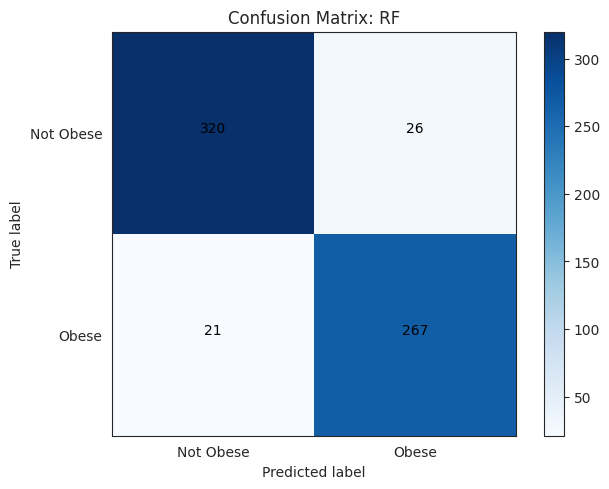

In [ ]:
print("--------RF--------")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 25,
                               class_weight = 'balanced_subsample')
model.fit(x_train_hybrid, y_train_hybrid)


y_predict = model.predict(x_test_hybrid)
#print(y_predict)
#print(y_test_label)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Not Obese','Obese']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: RF')

metrics.iloc[0,:] = ['RF',accuracy_score(y_test, y_predict),
                     f1_score(y_test, y_predict),
                     precision_score(y_test,y_predict)]

Balanced Random Forest

--------BRF--------


<ipython-input-12-a35de4488416>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  brf.fit(x_train_hybrid, y_train_hybrid)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.ut

Correctly classified instances: 587
Accuracy Score is 0.92587
Recall Score is 0.92708
Precision Score is 0.91126
F1 Score is 0.9191
     0    1
0  320   26
1   21  267
[[320  26]
 [ 21 267]]


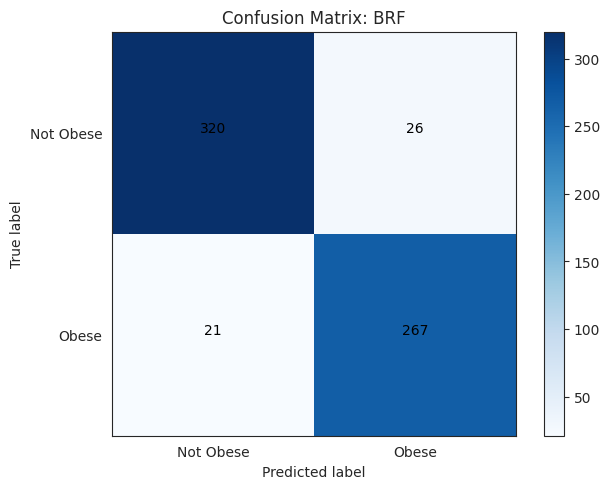

In [ ]:
print("--------BRF--------")
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=25)
brf.fit(x_train_hybrid, y_train_hybrid)


y_predict = model.predict(x_test_hybrid)
#print(y_predict)
#print(y_test_label)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Not Obese','Obese']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: BRF')

metrics.iloc[0,:] = ['RF',accuracy_score(y_test, y_predict),
                     f1_score(y_test, y_predict),
                     precision_score(y_test,y_predict)]

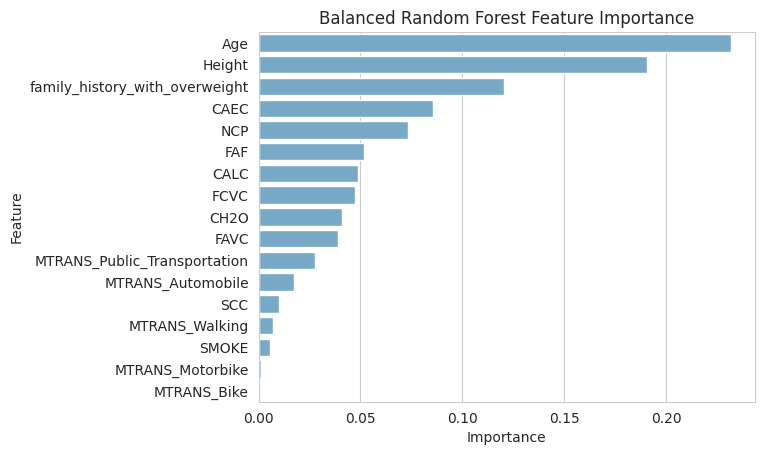

In [ ]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = brf.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train_hybrid.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances, color = color)
plt.title('Balanced Random Forest Feature Importance')
plt.savefig('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Term Paper/Interpretation Images/brf_feature_importance.jpeg', dpi=1200)
plt.show()

In [ ]:
type(x_test_hybrid)

pandas.core.frame.DataFrame

TypeError: ignored

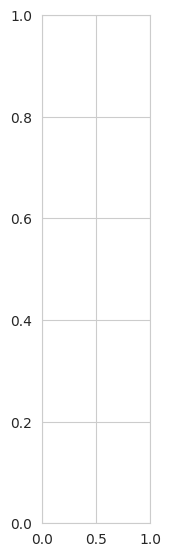

In [ ]:
import shap

# create an explainer object
explainer = shap.Explainer(model)

# calculate the shap values
shap_values = explainer(x_test_hybrid)

# plot the shap summary plot
shap.summary_plot(shap_values, x_test_hybrid, plot_type='dot')


In [ ]:
y_test.count()

634

2) Decision Tree ImBalanced

Use heuristic method to adjust the bias of the model

In [ ]:
# Count the number of 1's and 0's in y_test_label
num_ones = (y_train_hybrid == 1).sum()
num_zeros = (y_train_hybrid == 0).sum()

# Print the results
print('Number of ones:', num_ones)
print('Number of zeros:', num_zeros)

Number of ones: NObeyesdad    684
dtype: int64
Number of zeros: NObeyesdad    793
dtype: int64


In [ ]:
weights = {0:122,1:217} # Based on original training dataset

--------Decision Tree--------
Correctly classified instances: 547
Accuracy Score is 0.86278
Recall Score is 0.86111
Precision Score is 0.84068
F1 Score is 0.85077
     0    1
0  299   47
1   40  248
[[299  47]
 [ 40 248]]


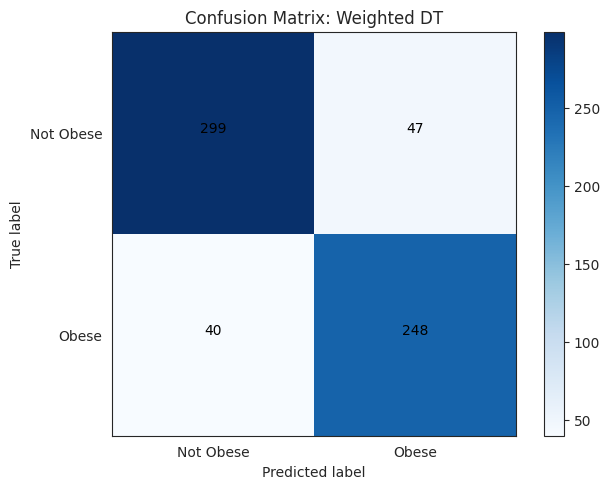

In [ ]:
print("--------Decision Tree--------")
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state = 42,
                                  class_weight = weights)

model_dt.fit(x_train_hybrid, y_train_hybrid)

y_predict = model_dt.predict(x_test_hybrid)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Not Obese','Obese']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: Weighted DT')

metrics.iloc[0,:] = ['DT',accuracy_score(y_test, y_predict),
                     f1_score(y_test, y_predict),
                     precision_score(y_test,y_predict)]

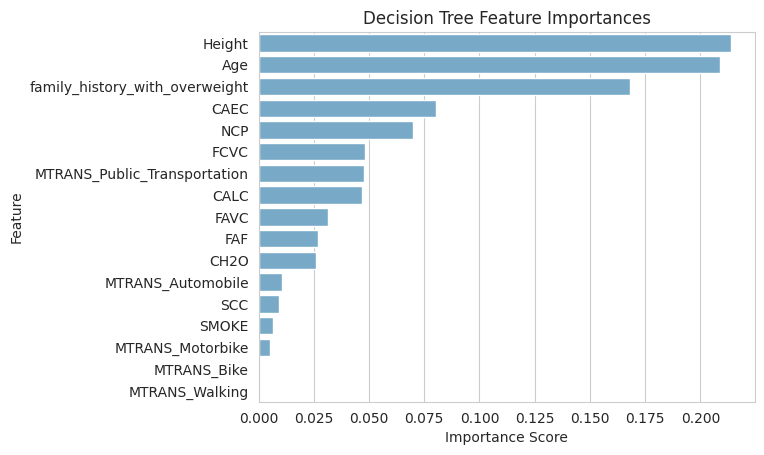

In [ ]:
# Feature Importance for Decision Tree
# plot feature importances
# define the color
color = cm.Blues(0.5)

importances = model_dt.feature_importances_
feature_importances = pd.DataFrame({'Feature': x_train_hybrid.columns,
                                    'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.barplot(x='Importance', y='Feature', data=feature_importances, color = color)
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Learning Rate for Decision Tree

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

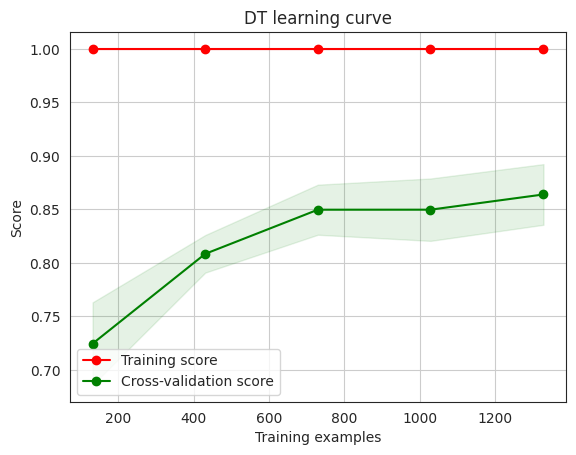

In [ ]:
plot_learning_curve(DecisionTreeClassifier(random_state = 42),
                    "DT learning curve",
                    x_train_hybrid, y_train_hybrid, cv= 10, n_jobs=4)
# start overfitting at a very early stage

3) Logistic Regression Baseline (BAD)

--------LR-------
Correctly classified instances: 502
Accuracy Score is 0.7918
Recall Score is 0.85764
Precision Score is 0.73077
F1 Score is 0.78914
     0    1
0  255   91
1   41  247
[[255  91]
 [ 41 247]]


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


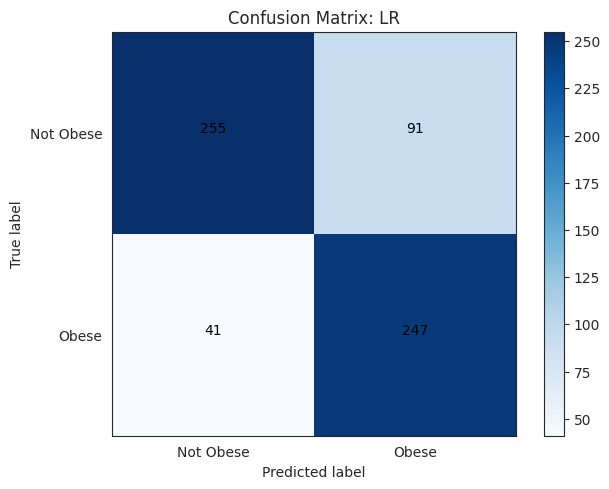

In [ ]:
print("--------LR-------")
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=100,random_state=42)
model.fit(x_train_hybrid, y_train_hybrid)


y_predict = model.predict(x_test_hybrid)

y_predict_fixed = np.logical_not(y_predict)
y_test_fixed = np.logical_not(y_test)

y_predict_fixed = y_predict_fixed.astype(int)
y_test_fixed = y_test_fixed.astype(int)
print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Not Obese','Obese']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: LR')

metrics.iloc[0,:] = ['LGBM',accuracy_score(y_test, y_predict), f1_score(y_test, y_predict), precision_score(y_test,y_predict)]

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

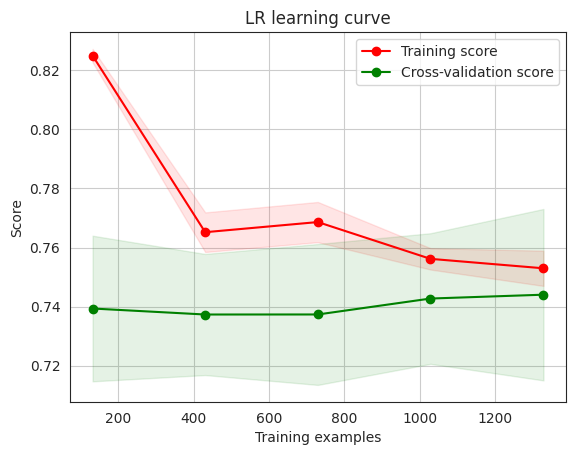

In [ ]:
plot_learning_curve(LogisticRegression(C=100,random_state=42),
                    "LR learning curve", x_train_hybrid, y_train_hybrid, 
                    cv= 10, n_jobs=4)

4) XGBOOST Weighted

Compute the Scale pos weight

In [9]:
# Using XGBOOST documentation
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
estimate = 217 / 122

--------XGBoost--------
Correctly classified instances: 576
Accuracy Score is 0.90852
Recall Score is 0.92014
Precision Score is 0.88333
F1 Score is 0.90136
     0    1
0  311   35
1   23  265
[[311  35]
 [ 23 265]]


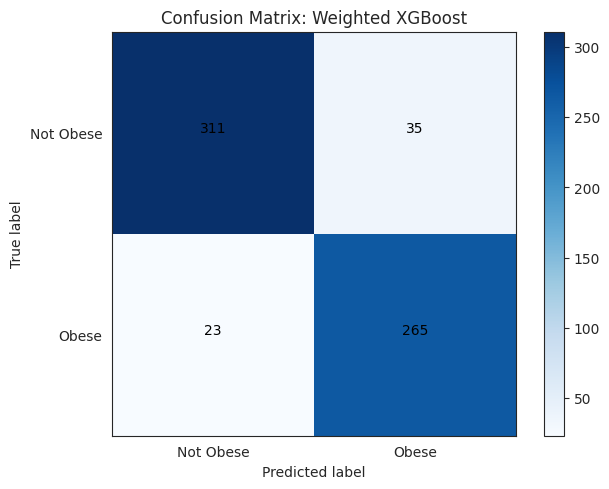

In [10]:
from xgboost import XGBClassifier
print("--------XGBoost--------")
xgb = XGBClassifier(booster = 'gbtree',
                    seed = 42,
                    scale_pos_weight = estimate)
xgb.fit(x_train_hybrid, y_train)

y_predict = xgb.predict(x_test_hybrid)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Not Obese','Obese']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: Weighted XGBoost')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb, x_train_hybrid, y_train, scoring='f1', cv=cv,
                         n_jobs=-1)
# summarize performance
scores

array([0.86567164, 0.92086331, 0.89705882, 0.90909091, 0.87769784,
       0.90510949, 0.93333333, 0.9037037 , 0.88590604, 0.91970803,
       0.88111888, 0.90647482, 0.89855072, 0.88111888, 0.90225564,
       0.84892086, 0.86330935, 0.86896552, 0.89855072, 0.90510949,
       0.92537313, 0.93430657, 0.92413793, 0.84892086, 0.90909091,
       0.91851852, 0.89361702, 0.88111888, 0.91304348, 0.84848485])

In [ ]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

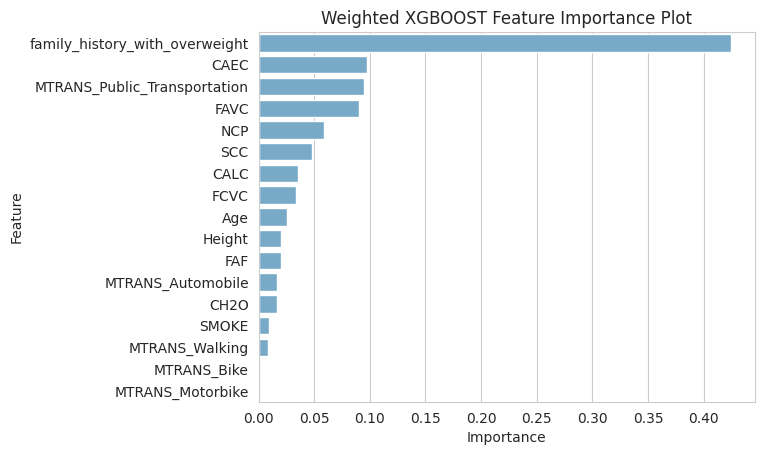

In [13]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = xgb.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train_hybrid.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances, color = color)

# add a title to the plot
plt.title('Weighted XGBOOST Feature Importance Plot')

# show the plot
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


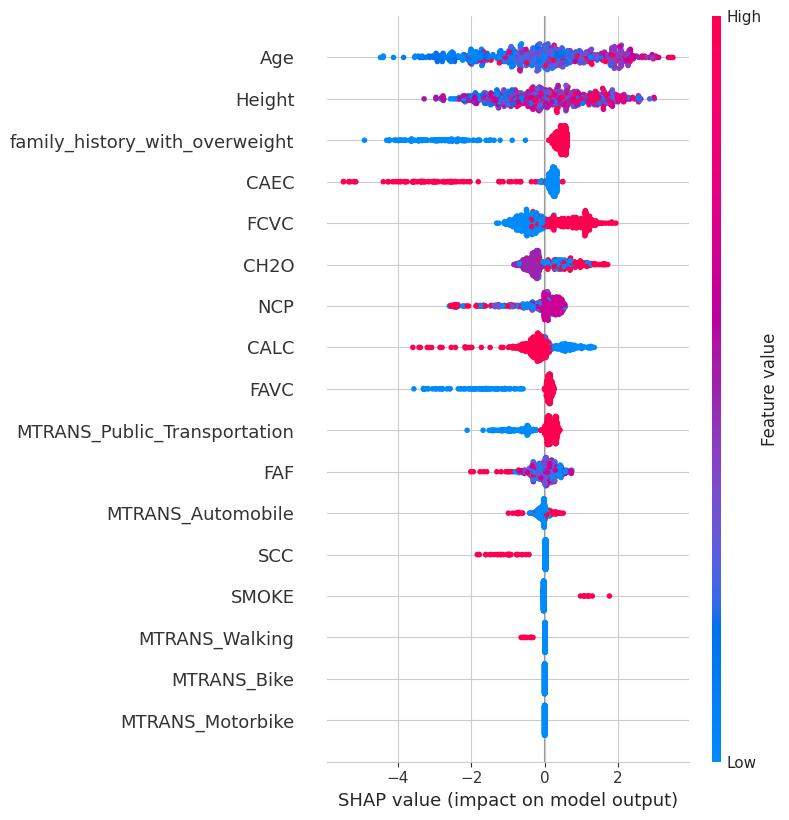

In [ ]:
import shap

# create an explainer object
explainer = shap.Explainer(xgb)

# calculate the shap values
shap_values = explainer(x_test_hybrid)

# plot the shap summary plot
shap.summary_plot(shap_values, x_test_hybrid, plot_type='dot')

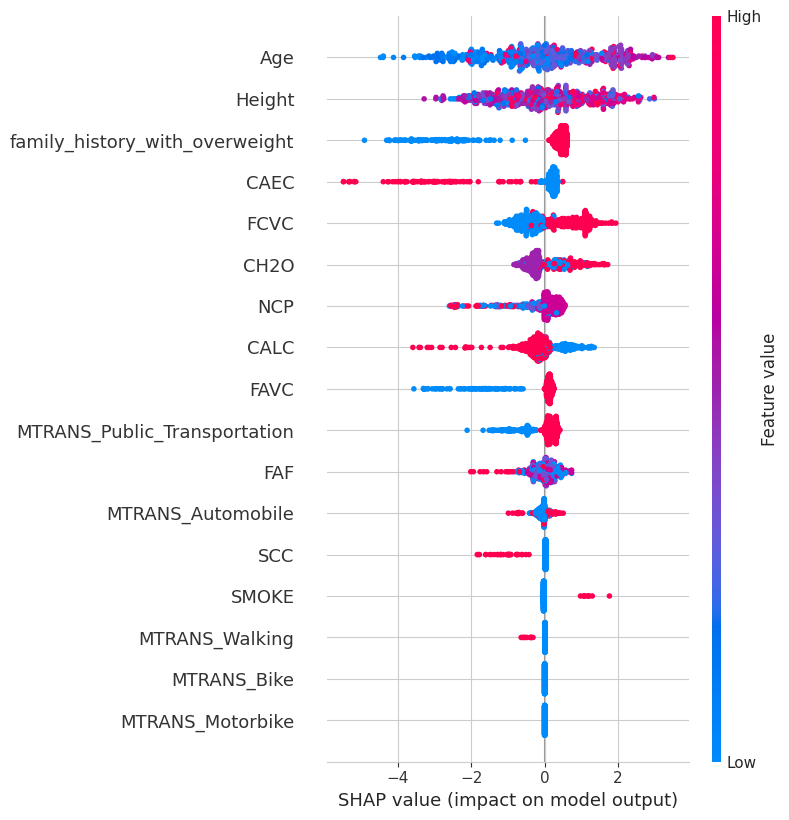

In [ ]:
shap.summary_plot(shap_values, 
                  x_test_hybrid,
                  plot_type='dot',
                  title='SHAP Summary Plot')

5) LightGBM Weighted with is_unbalanced on

--------LGBM--------


/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Correctly classified instances: 576
Accuracy Score is 0.90852
Recall Score is 0.92708
Precision Score is 0.87829
F1 Score is 0.90203
     0    1
0  309   37
1   21  267
[[309  37]
 [ 21 267]]


NameError: ignored

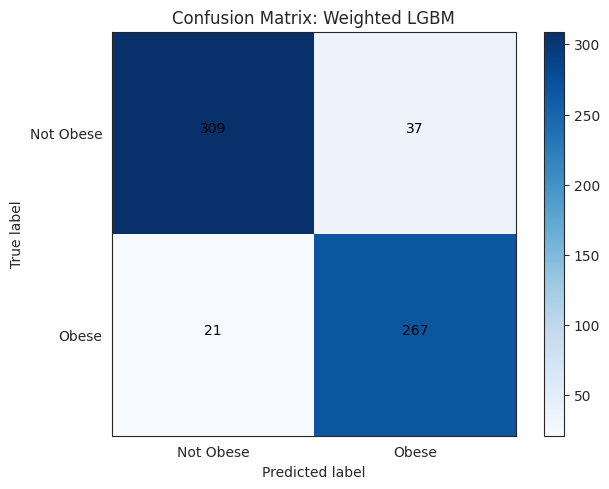

In [11]:
print("--------LGBM--------")
import lightgbm as lgb
model = lgb.LGBMClassifier(random_state = 42,
                           scale_pos_weight = 217/122)
model.fit(x_train_hybrid, y_train,
          categorical_feature=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                               16]
          )


y_predict = model.predict(x_test_hybrid)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Not Obese','Obese']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: Weighted LGBM')

metrics.iloc[0,:] = ['LGBM',accuracy_score(y_test, y_predict), f1_score(y_test, y_predict), precision_score(y_test,y_predict)]

Text(0, 0.5, 'Feature')

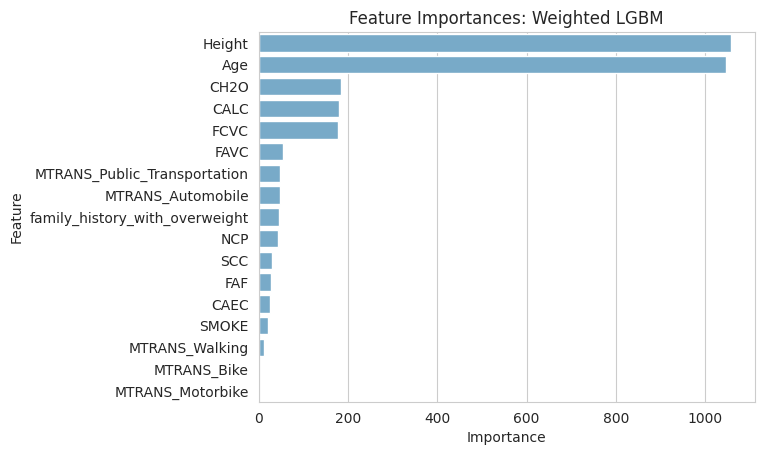

In [ ]:
# Get feature importances
importances = model.feature_importances_

# define the color
color = cm.Blues(0.5)

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train_hybrid.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances, color = color)
plt.title('Feature Importances: Weighted LGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')

TypeError: ignored

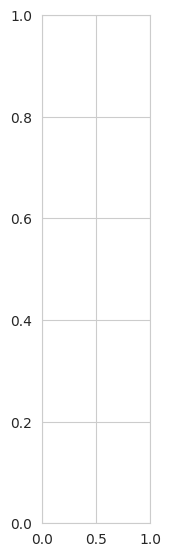

In [ ]:
import shap

# create an explainer object
explainer = shap.Explainer(model)

# calculate the shap values
shap_values = explainer(x_test_hybrid)

# plot the shap summary plot
shap.summary_plot(shap_values, x_test_hybrid, plot_type='dot')